In [1]:
!pip install kaggle scikit-learn matplotlib seaborn shap -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")


In [4]:
df = df.sample(n=200000, random_state=42)

In [5]:
print(df.head(10))

        step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
96826     10  CASH_OUT  118750.15  C1075796255           0.00            0.00   
93869     10   CASH_IN  178998.05   C381434908     6335961.52      6514959.57   
126825    11  CASH_OUT  282416.10   C672667631       11656.00            0.00   
6562       6  TRANSFER  179341.27  C1588148030       36003.00            0.00   
85878     10  CASH_OUT  323683.56  C1186935592           0.00            0.00   
86323     10  TRANSFER  600703.97   C256212161        1094.00            0.00   
58002      9  CASH_OUT  258769.64   C221010307        6996.00            0.00   
16412      8   CASH_IN   23076.49  C1419640968     4556739.48      4579815.96   
230560    14   CASH_IN  129249.92  C1366841825      338627.91       467877.83   
265414    15   PAYMENT    1508.92  C1278197479           0.00            0.00   

           nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
96826   C1911222122      1568

In [6]:
features = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
X = df[features].fillna(0)
y = df['isFraud']

In [7]:
# z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
model = IsolationForest(n_estimators=100, contamination=y.mean(), random_state=42)
model.fit(X_scaled)

IsolationForest(contamination=np.float64(0.000600003000015), random_state=42)

In [9]:
df['score'] = -model.decision_function(X_scaled)  # zyada score = zyada suspicious
df['pred'] = model.predict(X_scaled).astype(int)
df['pred'] = df['pred'].map({1: 0, -1: 1})  # -1 = anomaly, convert to 1

In [10]:
print(df['isFraud'].isna().sum())


1


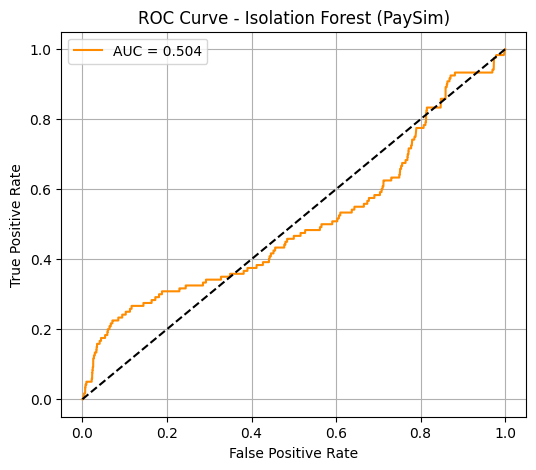

In [11]:
df['score'] = -model.decision_function(X_scaled)
# Remove rows with missing labels
df_clean = df.dropna(subset=['isFraud', 'score'])

y = df_clean['isFraud']
scores = df_clean['score']

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y, scores)
auc = roc_auc_score(y, scores)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest (PaySim)")
plt.legend()
plt.grid()
plt.show()


AUC = 0.504
This value is very close to 0.5, which means the model is performing **random guessing**.



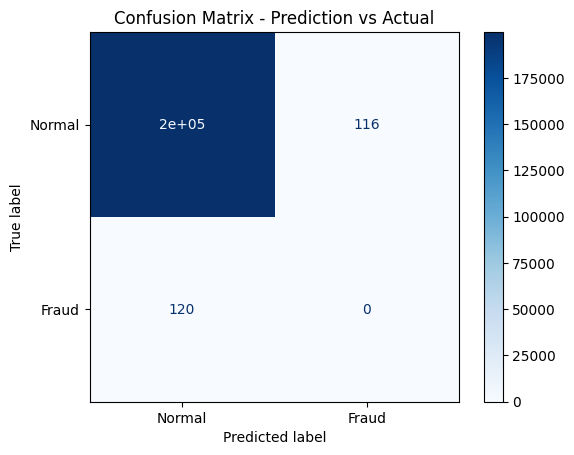

In [13]:
# Confusion Matrix
# Remove rows with missing 'isFraud' or 'pred'
df_cm = df.dropna(subset=['isFraud', 'pred'])

y_true = df_cm['isFraud']
y_pred = df_cm['pred']

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Fraud"])
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix - Prediction vs Actual")
plt.show()


The model failed to detect any fraud cases (recall = 0), misclassifying all as normal.
Despite high accuracy, it's ineffective due to extreme class imbalance and  **poor fraud detection == True Positive Rate**

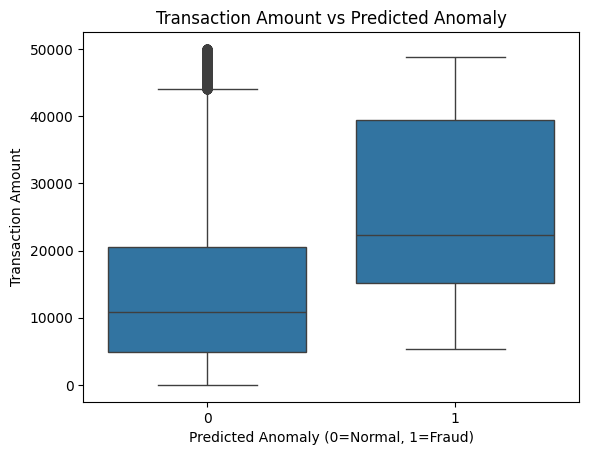

In [14]:
# amount vs predicted fraud
sns.boxplot(x='pred', y='amount', data=df[df['amount'] < 50000])
plt.title("Transaction Amount vs Predicted Anomaly")
plt.xlabel("Predicted Anomaly (0=Normal, 1=Fraud)")
plt.ylabel("Transaction Amount")
plt.show()

**Anomalies** predicted as frauds generally have **higher transaction amounts** than normal transactions.
Isolation Forest is likely associating large values with suspicious activity, though** not all might are truly fraud.**

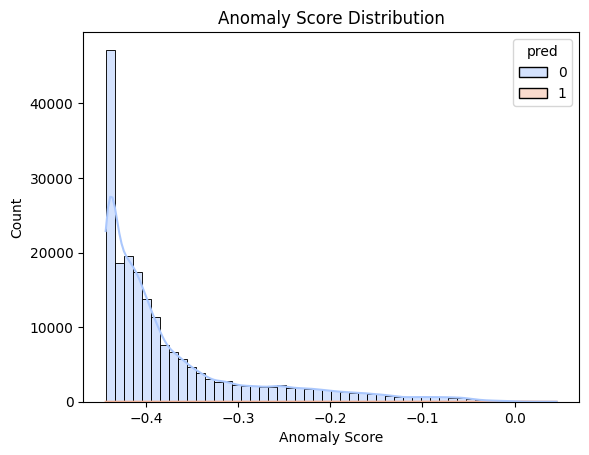

In [15]:
sns.histplot(data=df, x='score', hue='pred', bins=50, kde=True, palette='coolwarm')
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.show()

Most predicted normal transactions have low anomaly scores, clustered around –0.45.
Predicted anomalies are rare and only appear at the extreme high end of the anomaly score range.

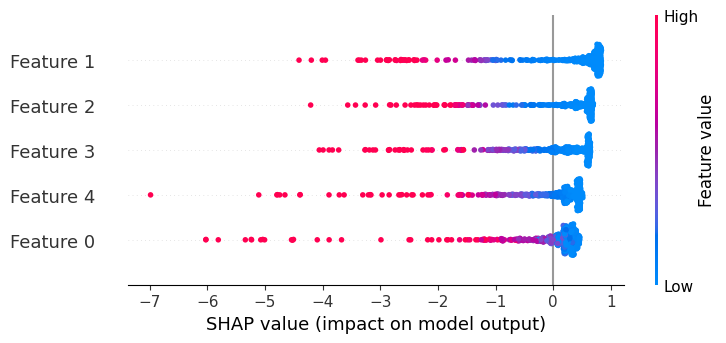

In [16]:
#  SHAP values --- how much each feature contributed to a model’s prediction
explainer = shap.Explainer(model, X_scaled[:500])
shap_values = explainer(X_scaled[:500])
shap.plots.beeswarm(shap_values)

**Feature 0 and Feature 1** have the strongest impact, contributing significantly to anomaly detection decisions.

In [17]:
# custom rule-based flag add
df['rule_based_flag'] = np.where((df['amount'] > 500000) & (df['newbalanceDest'] < 100), 1, 0)

# ML + rule combine final alert
df['final_flag'] = np.where((df['score'] > df['score'].quantile(0.99)) | (df['rule_based_flag'] == 1), 1, 0)


In [18]:
# Top 10 suspicious transaction
print(df[['amount', 'newbalanceDest', 'score', 'rule_based_flag', 'final_flag']].head(10))


           amount  newbalanceDest     score  rule_based_flag  final_flag
96826   118750.15      2401001.34 -0.377088                0           0
93869   178998.05       999421.84 -0.249492                0           0
126825  282416.10      1487976.41 -0.389418                0           0
6562    179341.27       179341.27 -0.418844                0           0
85878   323683.56      1207405.81 -0.394407                0           0
86323   600703.97       600703.97 -0.382686                0           0
58002   258769.64      1093834.46 -0.398807                0           0
16412    23076.49      2058343.75 -0.226402                0           0
230560  129249.92            0.00 -0.397347                0           0
265414    1508.92            0.00 -0.440361                0           0
